# Change in labor capacity

The fraction of the total capacity lost is given by

$$
Loss = \tfrac{1}{2}(1+ERF \left( \frac{WBGT-Prod_{mean}}{Prod_{SD} * \sqrt{2}} \right))
$$

Where WBGT is WBGTmax, WBGTmean or WBGThalf.  

| Work level | $Prod_{mean}$ | $Prod_{SD}$ |
|------------|---------------|-------------|
| 200        | 35.53         | 3.94        |
| 300        | 33.49         | 3.94        |
| 400        | 32.47         | 4.16        |



In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from joblib import Parallel, delayed
from scipy import stats
from scipy.special import erf

from tqdm.notebook import tqdm
from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

In [11]:
def labour_loss(wbgt, prod_mean, prod_sd):
    '''
    ..math:
        Loss = (1+ERF((WBGT-Prod_{mean})/(Prod_{SD} * \sqrt{2})))/2

    Args:
         WBGT is WBGTmax, WBGTmean or WBGThalf in Kelvin
         prod_mean is the mean productivity coefficient for a given power level
         prod_sd is the standard deviation coefficient for a given power level
    
    '''
    from scipy.special import erf
    root2 = 1.4142135623730951 # np.sqrt(2)
    return (1 + erf(((wbgt - 273.15) - prod_mean) / (prod_sd * root2))) / 2


def fraction_capacity_loss(wbgt, prod_mean, prod_sd):
    loss = labour_loss(wbgt, prod_mean, prod_sd)
    loss = xr.where(loss < 0.1, 0, loss)
    loss = xr.where(loss > 0.9, 0.9,  loss)
    return loss


def hours_capacity_loss(wbgt_mean, wbgt_max, wbgt_half, prod_mean, prod_sd):
    """
    model hourly WBGT using the 4+4+4 method giving a close approximation 
    to the hourly WBGT during the day. 4 hours per day at WBGTmax, 4 hours 
    at WBGThalf, and 4 hours at WBGTmean.
    
    2 extra conditions:  
    as people take micro-breaks during the hour we assume any work hours
    lost less than 10% is no work hours lost, and as everyone can do at 
    least 6 minutes/hour work even under extreme conditions, we assume 90% 
    work hours lost is a maximum.
    
    """    
    # Calculate the labour loss and clip it to the 10%/90% thresholds
    loss_mean = fraction_capacity_loss(wbgt_mean, prod_mean, prod_sd)
    
    loss_max = fraction_capacity_loss(wbgt_max, prod_mean, prod_sd)
    
    loss_half = fraction_capacity_loss(wbgt_half, prod_mean, prod_sd)
    
    loss_hours = 4 * loss_mean + 4 * loss_max + 4 * loss_half
    return loss_hours

In [4]:
MAX_YEAR = 2019
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005
YEARS = list(range(1980, MAX_YEAR+1))

RESULTS_FOLDER = Path('./results/labour').absolute()

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'

In [5]:
WBGT_MEAN_OUT = DATA_SRC / 'lancet' / 'wbgt_era5'  / 'daily_wbgtmean'
WBGT_MAX_OUT = DATA_SRC / 'lancet' / 'wbgt_era5'/ 'daily_wbgtmax'
WBGT_HALF_OUT = DATA_SRC / 'lancet' / 'wbgt_era5'/ 'daily_wbgthalf'

In [6]:
INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet' / 'labour_capacity' 

In [7]:
LOSS_FRACTION_OUT = INTERMEDIATE_RESULTS_FOLDER / 'loss_fraction_era5_2019_method'
LOSS_HOURS_OUT = INTERMEDIATE_RESULTS_FOLDER / 'loss_hours_era5_2019_method'

In [8]:
POWER_LEVEL_DATA = {
    200: (35.53,  3.94),
    300: (33.49, 3.94),
    400: (32.47, 4.16)
    }

## Plot the labour capacity function

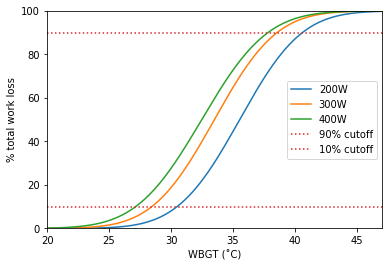

In [12]:
_wbgt = np.arange(20, 47, 0.1) + 273.15
labourcapacity = labour_loss(_wbgt, 35.53, 3.94)
plt.plot(_wbgt - 273.15, labourcapacity * 100, label='200W', color='C0')

labourcapacity = labour_loss(_wbgt, 33.49, 3.94)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='300W', color='C1')
                             
labourcapacity = labour_loss(_wbgt, 32.47, 4.16)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='400W', color='C2')

plt.axhline(90, label='90% cutoff', color='C3', linestyle=':')
plt.axhline(10, label='10% cutoff', color='C3', linestyle=':')

plt.legend()


plt.ylim(0, 100)
plt.xlim(20, 47)

plt.xlabel('WBGT (˚C)')
plt.ylabel('% total work loss')

plt.savefig(RESULTS_FOLDER / 'labour_loss_function.png', dpi=300)


### Plot the clipped version

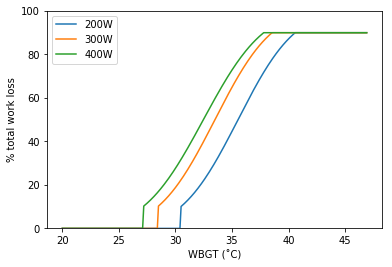

In [13]:
def _clip(lc):
    lc = xr.where(lc < 0.1, 0, lc)
    lc = xr.where(lc > 0.9, 0.9, lc)
    return lc

_wbgt = np.arange(20, 47, 0.1) + 273.15

labourcapacity = labour_loss(_wbgt, 35.53, 3.94)
labourcapacity = _clip(labourcapacity)

plt.plot(_wbgt - 273.15, labourcapacity * 100, label='200W')

labourcapacity = labour_loss(_wbgt, 33.49, 3.94)
labourcapacity = _clip(labourcapacity)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='300W')

labourcapacity = labour_loss(_wbgt, 32.47, 4.16)
labourcapacity = _clip(labourcapacity)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='400W')
plt.xlabel('WBGT (˚C)')
plt.ylabel('% total work loss')
plt.ylim(0, 100)
plt.legend()

plt.savefig(RESULTS_FOLDER / 'labour_loss_function_clip.png', dpi=300)

## Run the loss fraction calculation

## Run the hours lost per person working at given activity level calculation

Combine to one file with axis 'power level'

In [12]:
def calc_and_save(year, folder):
    wbgt_mean = xr.open_dataarray(WBGT_MEAN_OUT / f'wbgt_mean_{year}.nc')
    wbgt_max = xr.open_dataarray(WBGT_MAX_OUT / f'wbgt_max_{year}.nc')
    wbgt_half = xr.open_dataarray(WBGT_HALF_OUT / f'wbgt_half_{year}.nc')
    
    results = []
    for power, (prod_mean, prod_sd) in POWER_LEVEL_DATA.items():
        loss_hours = hours_capacity_loss(wbgt_mean, wbgt_max, wbgt_half, prod_mean, prod_sd)
        loss_hours.name = 'loss_hours'
        results.append(loss_hours.astype(np.float32))
    
    results = xr.concat(results, dim=pd.Index(POWER_LEVEL_DATA.keys(), name='power'))
    results.to_netcdf(folder / f'{year}_loss_hours.nc')
    return results     

In [15]:
out = Parallel(n_jobs=10, verbose=10)(delayed(calc_and_save)(year, LOSS_HOURS_OUT) for year in YEARS[-1:])

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.2min finished


# Calculate a baseline loss hours

For sharing

In [5]:
hours_lost_200 = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity'/ 'monthly_labour_loss_hours_200' / 'loss_hours_*.nc'))
hours_lost_300 = xr.open_mfdataset(str(DATA_SRC / 'lancet'/ 'labour_capacity' / 'monthly_labour_loss_hours_300' / 'loss_hours_*.nc'))
hours_lost_400 = xr.open_mfdataset(str(DATA_SRC / 'lancet'/ 'labour_capacity' / 'monthly_labour_loss_hours_400' / 'loss_hours_*.nc'))

# Calculate the yearly total hours lost for each power level
hours_lost_200 = hours_lost_200.groupby('time.year').sum(dim='time')
hours_lost_300 = hours_lost_300.groupby('time.year').sum(dim='time')
hours_lost_400 = hours_lost_400.groupby('time.year').sum(dim='time')

In [6]:
hours_lost = xr.concat([hours_lost_200, hours_lost_300, hours_lost_400], dim=pd.Index( [200, 300, 400], name='activity_level'))

In [7]:
loss_hours_reference = hours_lost.sel(year=slice(REFERENCE_YEAR_START,REFERENCE_YEAR_END)).mean(dim='year')


In [30]:
powers, datasets = zip(*loss_hours_reference.groupby('activity_level'))
paths = [DATA_SRC / 'lancet' / 'labour_capacity' / f'loss_hours_mean_{REFERENCE_YEAR_START}-{REFERENCE_YEAR_END}_{power_level}.nc' for power_level in powers]
xr.save_mfdataset(datasets, paths)